In [1]:
# %load_ext tensorboard
# fmt: off
from Utilities.Interpretability.ModelAugmentation import *
from Utilities.Interpretability.InterpretabilityMethods import *
from Utilities.Tasks.IntelNaturalScenesClassificationTask import IntelNaturalScenesClassificationTask as Task
from Utilities.SequentialLearning.EWC_Methods.EWC_Methods import * 

import os
import shutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# fmt: on
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
MODEL_SAVE_PATH = "models/IntelNaturalScenesClassification"
LOAD_MODEL = False
TRAIN_MODEL = not LOAD_MODEL

image_size = Task.IMAGE_SIZE
task_labels = [0,1]
model_input_shape = image_size
epochs = 25
training_batches = 0
validation_batches = 0
batch_size = 32
ewc_method = EWC_Method.FISHER_MATRIX

# Model Training and Architecture

In [3]:
model: tf.keras.Model
if LOAD_MODEL and os.path.exists(MODEL_SAVE_PATH):
    # Try to load model directly, if one exists
    print("LOADING MODEL")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH, compile=False)  # type: ignore
else:
    # Otherwise, make an entire new model!
    print("CREATING MODEL")
    model_inputs = model_layer = tf.keras.Input(shape=model_input_shape)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_0")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_1")(model_layer)
    model_layer = tf.keras.layers.BatchNormalization()(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_2")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_3")(model_layer)
    model_layer = tf.keras.layers.BatchNormalization()(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_4")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_5")(model_layer)
    model_layer = tf.keras.layers.BatchNormalization()(model_layer)
    # model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_6")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_7")(model_layer)
    model_layer = tf.keras.layers.Conv2D(16, (3,3), activation="relu", name="conv2d_9")(model_layer)
    model_layer = tf.keras.layers.BatchNormalization()(model_layer)
    model_layer = tf.keras.layers.Flatten()(model_layer)
    model_layer = tf.keras.layers.Dense(32, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dropout(0.2)(model_layer)
    model_layer = tf.keras.layers.Dense(32, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dropout(0.2)(model_layer)
    model_layer = tf.keras.layers.Dense(len(task_labels))(model_layer)
    model = tf.keras.Model(inputs=model_inputs, outputs=model_layer, name="base_model")
if len(task_labels) == 2:
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
else:
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.summary()

CREATING MODEL
Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_0 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 146, 146, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 7

In [4]:
training_image_augmentation = None
# training_image_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomZoom(
#             height_factor=(-0.05, -0.25),
#             width_factor=(-0.05, -0.25)),
#     tf.keras.layers.RandomRotation(0.05, "constant")
# ])

task = Task(
        name=f"Task 0",
        model=model,
        model_base_loss=loss_fn,
        task_labels=task_labels,
        training_batches = 0,
        validation_batches = 0,
        batch_size=batch_size,
        training_image_augmentation = training_image_augmentation,
        image_size=image_size[:2]
    )
ewc_term_creator = EWC_Term_Creator(ewc_method, model, [task])

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


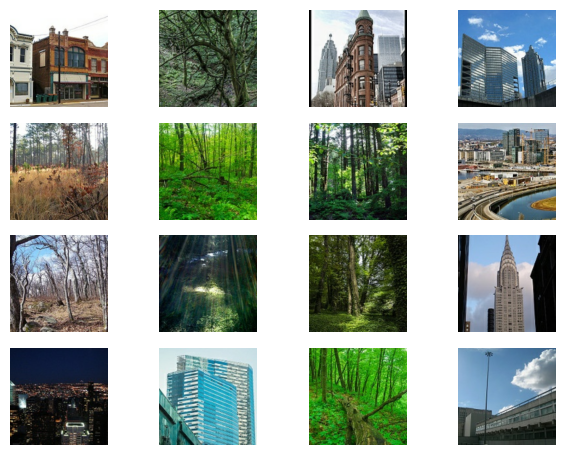

In [ ]:
NUM_DATA = 16
# Show some images from the task dataset
data = task.validation_dataset.take(1)
data_images, data_labels = data.as_numpy_iterator().next()
data_images = data_images[:NUM_DATA]
data_labels = data_labels[:NUM_DATA]
plot_images(data_images)

In [6]:
if TRAIN_MODEL:
    checkpoint_path = MODEL_SAVE_PATH+"/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1)
    if os.path.isdir("./logs/TensorBoards"):
        shutil.rmtree("./logs/TensorBoards")
    history = task.train_on_task(epochs=epochs, callbacks=[
#         checkpoint_callback, 
        tf.keras.callbacks.TensorBoard(log_dir='./logs/TensorBoard'),
        *ewc_term_creator.callback_dict.values(),
    ])
    model.save(MODEL_SAVE_PATH)
else:
    print(f"{TRAIN_MODEL=}")
ewc_term = ewc_term_creator.create_term(ewc_lambda = 1)

Epoch 1/25
139/139 [==============================] - 31s 142ms/step - loss: 0.5651 - base_loss: 0.5651 - val_loss: 0.6990 - val_base_loss: 0.6990
Epoch 2/25
139/139 [==============================] - 23s 158ms/step - loss: 0.2850 - base_loss: 0.2850 - val_loss: 0.5424 - val_base_loss: 0.5424
Epoch 3/25
139/139 [==============================] - 24s 174ms/step - loss: 0.1994 - base_loss: 0.1994 - val_loss: 0.1822 - val_base_loss: 0.1822
Epoch 4/25
139/139 [==============================] - 23s 169ms/step - loss: 0.1746 - base_loss: 0.1746 - val_loss: 0.2312 - val_base_loss: 0.2312
Epoch 5/25
139/139 [==============================] - 21s 148ms/step - loss: 0.1586 - base_loss: 0.1586 - val_loss: 0.1669 - val_base_loss: 0.1669
Epoch 6/25
139/139 [==============================] - 21s 153ms/step - loss: 0.1331 - base_loss: 0.1331 - val_loss: 0.7700 - val_base_loss: 0.7700
Epoch 7/25
139/139 [==============================] - 22s 158ms/step - loss: 0.1138 - base_loss: 0.1138 - val_loss: 0.

INFO:tensorflow:Assets written to: models/IntelNaturalScenesClassification/assets


INFO:tensorflow:Assets written to: models/IntelNaturalScenesClassification/assets


--------------------------------------------------------------------------------
STARTING FISHER CALCULATION
FINISHED FISHER CALCULATION
--------------------------------------------------------------------------------


In [7]:
threshold_model = threshold_model_by_omega(task.model, ewc_term.omega_matrix, 
    threshold_percentage = 0.2,
    comparison_method = ComparisonMethod.LAYER_WISE,
    aggregation_level = AggregationLevel.NO_AGGREGATION,
    aggregation_method = AggregationMethod.MEAN_AVERAGE,
)

LAYER_WISE layer_index=1 conv2d_0 threshold_value=7.0519123
LAYER_WISE layer_index=2 conv2d_1 threshold_value=1.8578477e-07
LAYER_WISE layer_index=3 batch_normalization threshold_value=29.995167
LAYER_WISE layer_index=5 conv2d_2 threshold_value=0.037382383
LAYER_WISE layer_index=6 conv2d_3 threshold_value=46.766964
LAYER_WISE layer_index=7 batch_normalization_1 threshold_value=359.81607
LAYER_WISE layer_index=9 conv2d_4 threshold_value=50.0556
LAYER_WISE layer_index=10 conv2d_5 threshold_value=14.573385
LAYER_WISE layer_index=11 batch_normalization_2 threshold_value=161.88574
LAYER_WISE layer_index=12 conv2d_6 threshold_value=10.847463
LAYER_WISE layer_index=13 conv2d_7 threshold_value=4.768651
LAYER_WISE layer_index=14 conv2d_9 threshold_value=0.0021363862
LAYER_WISE layer_index=15 batch_normalization_3 threshold_value=25.904924
LAYER_WISE layer_index=18 dense threshold_value=0.6150105
LAYER_WISE layer_index=20 dense_1 threshold_value=0.0
LAYER_WISE layer_index=22 dense_2 threshold_va

## Validation Testing

In [8]:
print(f"ORIGINAL  MODEL: {task.model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")
print(f"THRESHOLD MODEL: {threshold_model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")

28/28 [==============================] - 2s 34ms/step - loss: 0.0842 - base_loss: 0.0842
ORIGINAL  MODEL: {'loss': 0.08419669419527054, 'base_loss': 0.08419669419527054}
28/28 [==============================] - 2s 33ms/step - loss: 0.2640
THRESHOLD MODEL: {'loss': 0.26402029395103455}


# Interpretability Methods

## Kernel Activations

In [10]:
kernel_activations(model=task.model, steps=50, step_size=0.01, layer_name="conv2d_4")

OPERATING ON conv2d_4


TypeError: 'NoneType' object cannot be interpreted as an integer

In [ ]:
kernel_activations(model=threshold_model, steps=50, step_size=0.01, layer_name="conv2d_1")

## Occlusion Sensitivity

IMAGE 1/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 2/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 3/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 4/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 5/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 6/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 7/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 8/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 9/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 10/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 11/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 12/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 13/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 14/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 15/16
PATCHES PROCESSED 21506 (253, 253)
IMAGE 16/16
PATCHES PROCESSED 21506 (253, 253)


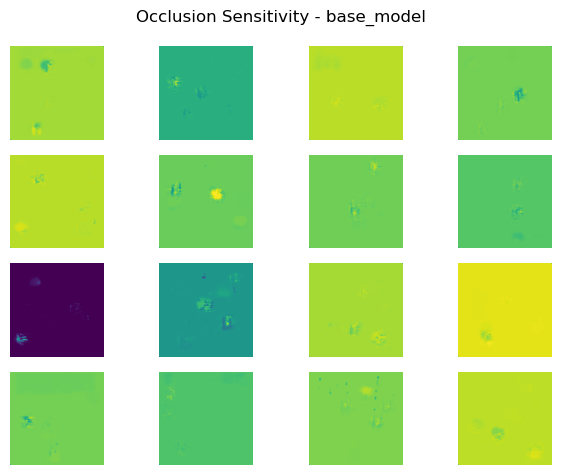

In [13]:
occlusion_sensitivity(task.model, data_images, data_labels, patch_size=3, stride=3, occlusion_batch_size=32)

In [ ]:
occlusion_sensitivity(threshold_model, data_images, data_labels, patch_size=2, stride=1)

## GRADCAM

HEATMAP RANGE (EXTREME): 0.03629803657531738
HEATMAP RANGE (AVG): 0.02147727459669113


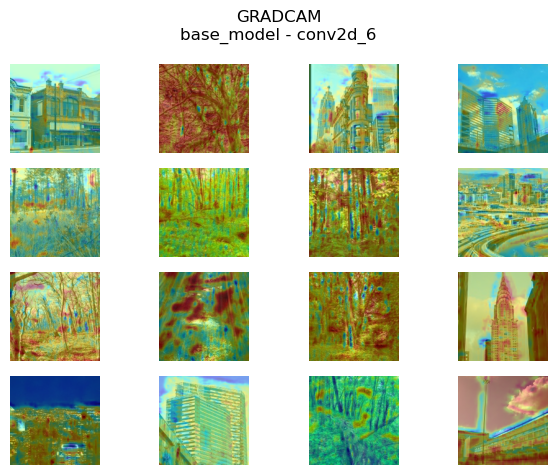

In [16]:
ALPHA = 0.6
BETA = 1-ALPHA

GRADCAM(task.model, data_images, data_labels, layer_name="conv2d_6",
    alpha=ALPHA, beta=BETA,
    show_predictions=0, absolute_scale=None)

In [ ]:
GRADCAM(threshold_model, data_images, data_labels, layer_name="conv2d_3", 
    alpha=ALPHA, beta=BETA,
    show_predictions=0, absolute_scale=0.26)